In [1]:

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


seed_value = 71
tf.random.set_seed(seed_value)
np.random.seed(seed_value)    
random.seed(seed_value)       


2024-12-19 20:19:41.453396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 20:19:41.472418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734614381.497586 2685741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734614381.503886 2685741 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 20:19:41.527624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

def load_data(directory, img_size=(224, 224), batch_size=32):

    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset


data_directory = "Dataset UAS" 
dataset = load_data(data_directory)


class_names = dataset.class_names
print(f"Class names: {class_names}")


Found 330 files belonging to 3 classes.
Class names: ['PaprikaHijauFix', 'PaprikaKuningFix', 'PaprikaMerahFix']


W0000 00:00:1734614384.114357 2685741 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2024-12-19 20:19:44.585828: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


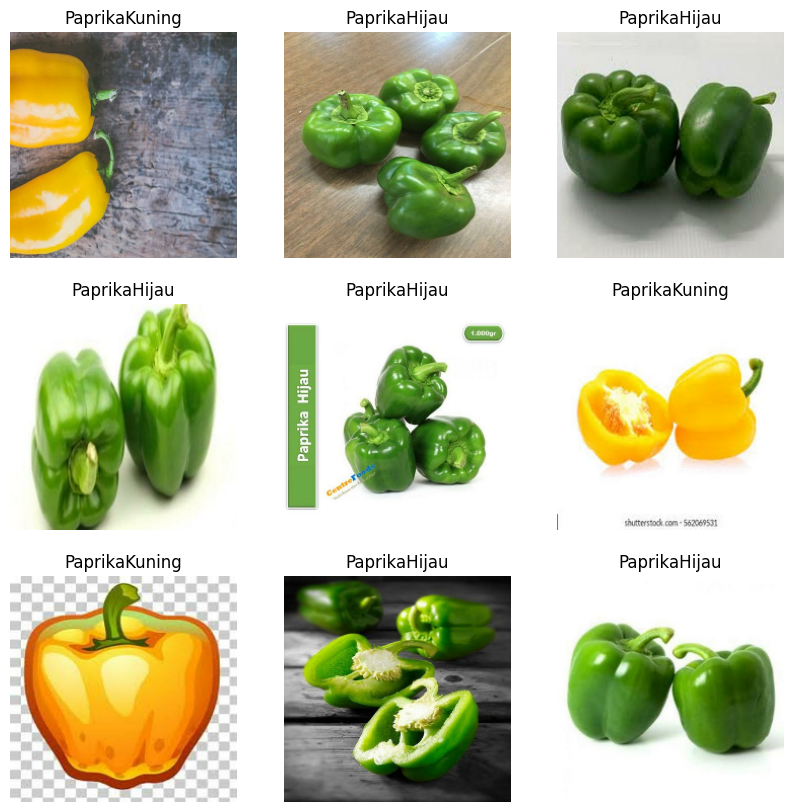

In [3]:

def visualize_data(dataset, num_images=9):
    label_map = {
        'PaprikaHijauFix': 'PaprikaHijau',
        'PaprikaKuningFix': 'PaprikaKuning',
        'PaprikaMerahFix': 'PaprikaMerah'
    }
    
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Map label index to class name and custom label
            label_name = class_names[labels[i]]
            custom_label = label_map.get(label_name, "Unknown")
            plt.title(custom_label)
            plt.axis("off")
    plt.show()


visualize_data(dataset)


In [4]:

augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:

def normalize_data(dataset):
    return dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):

    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)

    train_dataset = dataset.take(train_size)
    val_test_dataset = dataset.skip(train_size)
    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

train_ds, val_ds, test_ds = split_dataset(dataset)

train_ds = normalize_data(train_ds)
val_ds = normalize_data(val_ds)
test_ds = normalize_data(test_ds)

print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")


Train size: 8, Validation size: 1, Test size: 2


In [6]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=3):

    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape,
               kernel_regularizer=l2(0.01)),
        MaxPooling2D((3, 3), strides=2),
        BatchNormalization(),
        Dropout(0.3), 
        
        Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D((3, 3), strides=2),
        BatchNormalization(),
        Dropout(0.3),  
        
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2),
        BatchNormalization(),
        Dropout(0.3),  
        
        Flatten(),
        Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_alexnet()
model.summary()


/opt/tljh/user/envs/dltf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,761,731 (178.38 MB)

 Trainable params: 46,760,515 (178.38 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.4834 - loss: 98.8750 - val_accuracy: 0.3750 - val_loss: 128.4318 - learning_rate: 0.0010
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.9114 - loss: 83.8901 - val_accuracy: 0.3125 - val_loss: 96.0019 - learning_rate: 0.0010
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.9370 - loss: 73.8499 - val_accuracy: 0.5625 - val_loss: 126.1317 - learning_rate: 0.0010
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.9097 - loss: 65.1119 - val_accuracy: 0.3750 - val_loss: 94.7901 - learning_rate: 0.0010
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.9724 - loss: 55.8687 - val_accuracy: 0.6562 - val_loss: 59.6748 - learning_rate: 0.0010
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.9741 - loss: 48.1750 - val_accuracy: 0.9375 - val_loss: 42.2939 - learning_rate: 0.0010
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.9765 - loss: 40.5259 -

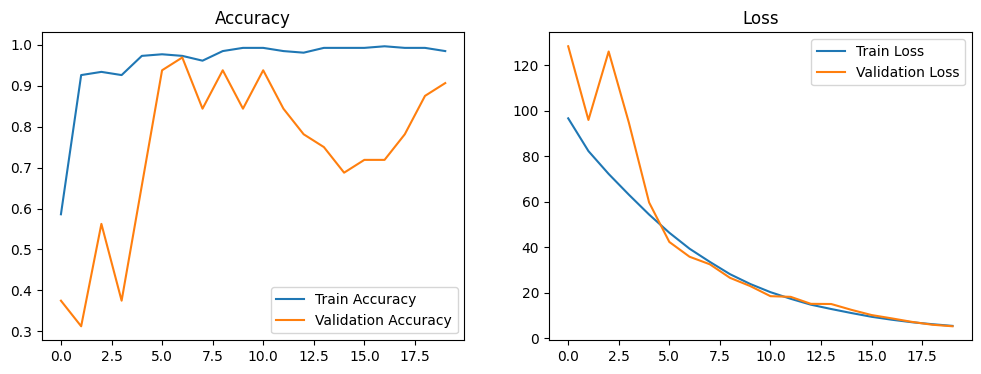

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

def train_model(model, train_ds, val_ds, epochs=20):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[lr_scheduler, early_stopping]
    )

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()
    return history

history = train_model(model, train_ds, val_ds)


In [8]:
def evaluate_model(model, test_ds):

    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test Accuracy: {test_acc:.2f}")

evaluate_model(model, test_ds)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9737 - loss: 5.0376 
Test Accuracy: 0.98


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    
    cm = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_names
    )
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9420 - loss: 5.3302 
Test Accuracy: 0.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2024-12-19 20:20:26.239342: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


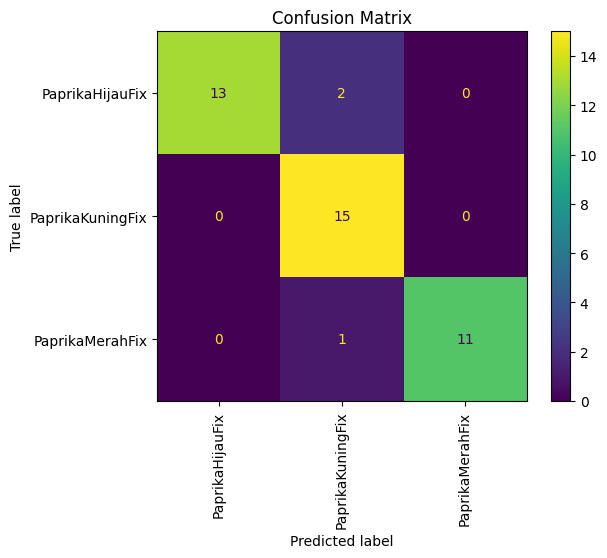

In [10]:
evaluate_model(model, test_ds)

plot_confusion_matrix(model, test_ds)


In [11]:
model.save("BestModel_AlexNet_Seaborn.h5")
print("Model saved as alexnet_paprika.h5")


Model saved as alexnet_paprika.h5


In [12]:
from tensorflow.keras.models import load_model

model_path = "BestModel_AlexNet_Seaborn.h5" 
loaded_model = load_model(model_path)
print("Model loaded successfully.")


Model loaded successfully.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_entire_dataset(model, datasets, dataset_names):

    for ds, name in zip(datasets, dataset_names):
        print(f"\nEvaluating on {name} Dataset:")
        
        loss, accuracy = model.evaluate(ds)
        print(f"{name} Accuracy: {accuracy:.2f}")
        print(f"{name} Loss: {loss:.2f}")

        y_true = []
        y_pred = []

        for images, labels in ds:
            predictions = model.predict(images)
            y_true.extend(labels.numpy())
            y_pred.extend(np.argmax(predictions, axis=1))

        print(f"\n{name} Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=class_names
        )
        disp.plot(cmap='viridis', xticks_rotation='vertical')
        plt.title(f"{name} Confusion Matrix")
        plt.show()



Evaluating on Train Dataset:
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9363 - loss: 5.2468
Train Accuracy: 0.93
Train Loss: 5.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Train Classification Report:
                  precision    recall  f1-score   support

 PaprikaHijauFix       1.00      0.78      0.88        87
PaprikaKuningFix       0.81      1.00      0.90        81
 PaprikaMerahFix       0.97      0.97      0.97        88

        accuracy                           0.91       256
       macro avg       0.93      0.92      0.91       256
    weighted avg       0.93      0.91      0.91       256



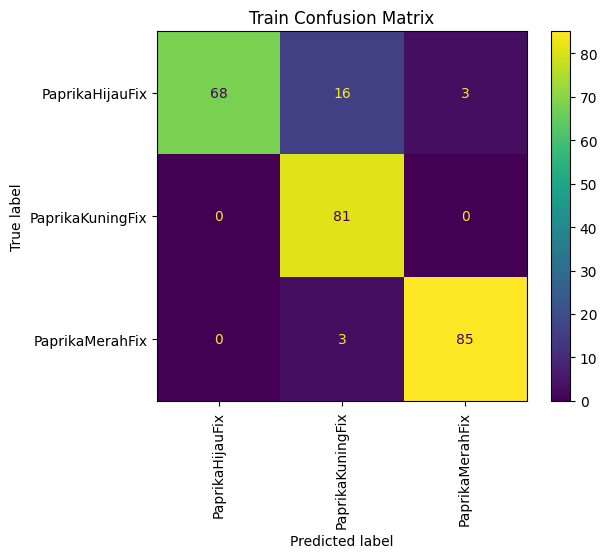


Evaluating on Validation Dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9062 - loss: 5.3316
Validation Accuracy: 0.91
Validation Loss: 5.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

Validation Classification Report:
                  precision    recall  f1-score   support

 PaprikaHijauFix       1.00      0.78      0.88         9
PaprikaKuningFix       0.86      1.00      0.92        12
 PaprikaMerahFix       1.00      1.00      1.00        11

        accuracy                           0.94        32
       macro avg       0.95      0.93      0.93        32
    weighted avg       0.95      0.94      0.94        32



2024-12-19 20:20:31.291983: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


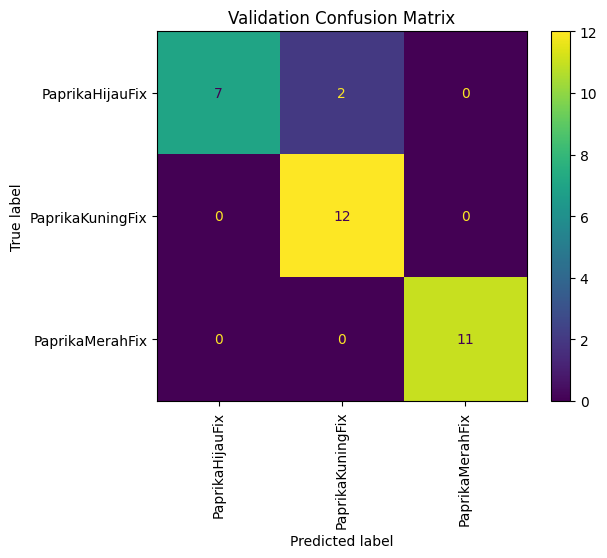


Evaluating on Test Dataset:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8948 - loss: 5.4322 
Test Accuracy: 0.90
Test Loss: 5.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

Test Classification Report:
                  precision    recall  f1-score   support

 PaprikaHijauFix       1.00      1.00      1.00        14
PaprikaKuningFix       0.93      1.00      0.97        14
 PaprikaMerahFix       1.00      0.93      0.96        14

        accuracy                           0.98        42
       macro avg       0.98      0.98      0.98        42
    weighted avg       0.98      0.98      0.98        42



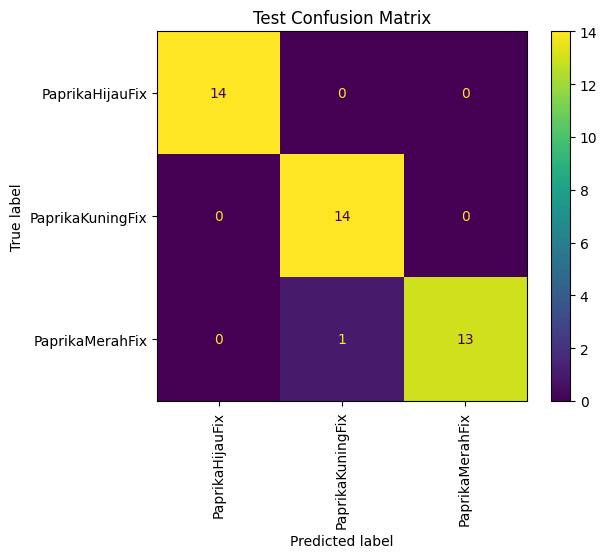

In [14]:
evaluate_entire_dataset(
    model=loaded_model,
    datasets=[train_ds, val_ds, test_ds],
    dataset_names=["Train", "Validation", "Test"]
)


In [15]:
print("Made Ivan Jayasavitra Girinata / 220712063/ Seaborn/ Perbedaan Paprika Merah, Kuning Hijau Menggunaakn AlexNet")

Made Ivan Jayasavitra Girinata / 220712063/ Seaborn/ Perbedaan Paprika Merah, Kuning Hijau Menggunaakn AlexNet
